# Initialize the accelerator

In [1]:
from finn_examples import models
print(list(filter(lambda x: "cifar10" in x, dir(models))))

['_cifar10_cnv_io_shape_dict', 'cnv_w1a1_cifar10', 'cnv_w1a2_cifar10', 'cnv_w2a2_cifar10']


In [2]:
accel = models.cnv_w1a1_cifar10()

In [3]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal), str(accel.idt)))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal), str(accel.odt)))

Expected input shape and datatype: (1, 32, 32, 3) DataType.UINT8
Expected output shape and datatype: (1, 1) DataType.UINT8


# Load the CIFAR-10 dataset

Use the `dataset_loading` package to get easy Python access to CIFAR-10 dataset:

In [4]:
from dataset_loading import cifar
trainx, trainy, testx, testy, valx, valy = cifar.load_cifar_data("/tmp", download=True, one_hot=False)

Download URL: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Download DIR: /tmp
>> Downloading cifar-10-python.tar.gz 100.0%
Extracting Python CIFAR10 data.
Files extracted


In [5]:
testx.shape

(10000, 32, 32, 3)

# Classify a single image

In [11]:
test_single_x = testx[0]
test_single_y = testy[0]
cifar10_class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


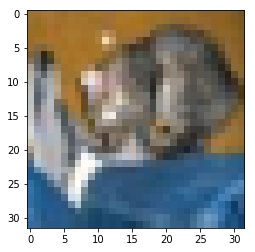

In [8]:
from matplotlib import pyplot as plt

plt.imshow(test_single_x)
plt.show()

In [12]:
print("Expected class is %d (%s)" % (test_single_y, cifar10_class_names[test_single_y]))

Expected class is 3 (Cat)


In [13]:
accel_in = test_single_x.reshape(accel.ishape_normal)
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 32, 32, 3) and datatype is uint8


In [14]:
accel_out = accel.execute(accel_in)

In [15]:
print("Returned class is %d" % accel_out)

Returned class is 3


In [16]:
%%timeit
accel_out = accel.execute(accel_in)

1 loop, best of 3: 3.27 s per loop


# Go faster: skip unneeded data packing/unpacking

FINN-generated accelerators pack few-bit values next to each other to save on memory and bandwidth. For instance, four 2-bit values can be packed into an 8-bit word.

The `accel.execute()` function takes a regular (unpacked) numpy array and performs the appropriate packing for the accelerator at hand, and performs unpacking on the result before returning it. However, in some cases it's not necessary to do any data packing and unpacking:

In [17]:
print("Input datatype is %s, normal shape is %s, folded shape is %s, packed shape is %s" % (accel.idt, accel.ishape_normal, accel.ishape_folded, accel.ishape_packed))
print("Output datatype is %s, normal shape is %s, folded shape is %s, packed shape is %s" % (accel.odt, accel.oshape_normal, accel.oshape_folded, accel.oshape_packed))

Input datatype is DataType.UINT8, normal shape is (1, 32, 32, 3), folded shape is (1, 1, 32, 32, 1, 3), packed shape is (1, 1, 32, 32, 1, 3)
Output datatype is DataType.UINT8, normal shape is (1, 1), folded shape is (1, 1, 1), packed shape is (1, 1, 1)


Since this accelerator uses uint8 inputs, the normal, folded and packed shapes are all the same (just with an extra dummy dimension), so we can skip all software preprocessing to pack the input data, writing the image straight into the accelerator buffers and executing it straight away.

In [18]:
# prepare input/output buffer
accel_in_reshaped = accel_in.reshape(accel.ishape_packed)
import numpy as np
out_buf = np.empty_like(accel.obuf_packed_device)

In [19]:
accel.copy_input_data_to_device(accel_in_reshaped)
accel.execute_on_buffers()
accel.copy_output_data_from_device(out_buf)

In [20]:
print(out_buf)

[[[3]]]


Let's see how much faster we got:

In [21]:
%%timeit -n 10
accel.copy_input_data_to_device(accel_in_reshaped)

10 loops, best of 3: 238 µs per loop


In [22]:
%%timeit -n 10
accel.execute_on_buffers()

10 loops, best of 3: 1.68 ms per loop


In [23]:
%%timeit -n 10
accel.copy_output_data_from_device(out_buf)

10 loops, best of 3: 145 µs per loop


# Validate accuracy on entire CIFAR-10 test set

In [24]:
batch_size = 1000
total = testx.shape[0]
accel.batch_size = batch_size
n_batches = int(total / batch_size)

batch_imgs = testx.reshape(n_batches, batch_size, -1)
batch_labels = testy.reshape(n_batches, batch_size)
obuf_normal = np.empty_like(accel.obuf_packed_device)
print("Ready to run validation, test images tensor has shape %s" % str(batch_imgs.shape))
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed), str(accel.oshape_packed)) )

Ready to run validation, test images tensor has shape (10, 1000, 3072)
Accelerator buffer shapes are (1000, 1, 32, 32, 1, 3) for input, (1000, 1, 1) for output


In [25]:
ok = 0
nok = 0
for i in range(n_batches):
    ibuf_normal = batch_imgs[i].reshape(accel.ishape_packed)
    exp = batch_labels[i]
    accel.copy_input_data_to_device(ibuf_normal)
    accel.execute_on_buffers()
    accel.copy_output_data_from_device(obuf_normal)
    ret = np.bincount(obuf_normal.flatten() == exp.flatten())
    nok += ret[0]
    ok += ret[1]
    print("batch %d / %d : total OK %d NOK %d" % (i, n_batches, ok, nok))

batch 0 / 10 : total OK 851 NOK 149
batch 1 / 10 : total OK 1683 NOK 317
batch 2 / 10 : total OK 2522 NOK 478
batch 3 / 10 : total OK 3370 NOK 630
batch 4 / 10 : total OK 4207 NOK 793
batch 5 / 10 : total OK 5044 NOK 956
batch 6 / 10 : total OK 5887 NOK 1113
batch 7 / 10 : total OK 6728 NOK 1272
batch 8 / 10 : total OK 7570 NOK 1430
batch 9 / 10 : total OK 8419 NOK 1581


In [26]:
acc = 100.0 * ok / (total)
print("Final accuracy: {}%".format(acc))

Final accuracy: 84.19%


In [27]:
def run_validation():
    for i in range(n_batches):
        ibuf_normal = batch_imgs[i].reshape(accel.ishape_packed)
        exp = batch_labels[i]
        accel.copy_input_data_to_device(ibuf_normal)
        accel.execute_on_buffers()
        accel.copy_output_data_from_device(obuf_normal)

In [28]:
full_validation_time = %timeit -n 5 -o run_validation()

5 loops, best of 3: 3.49 s per loop


In [29]:
print("%f images per second including data movement" % (total / float(full_validation_time.best)))

2867.733423 images per second including data movement


In [30]:
accel_time = %timeit -n {n_batches} -o accel.execute_on_buffers()

10 loops, best of 3: 331 ms per loop


In [31]:
print("%f images per second excluding data movement" % (total / float(accel_time.best)))

30203.160870 images per second excluding data movement
